In [1]:
import json
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm
from IPython import display

from scipy.misc import imresize
from scipy.ndimage.interpolation import rotate

# Keras imports
from keras.models import Sequential, Model
from keras.layers import Conv2DTranspose, Reshape, UpSampling2D, Dense, Add, Activation, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, Input, LeakyReLU, BatchNormalization, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg19 import VGG19
from keras.optimizers import RMSprop, Adagrad, SGD, Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.


### Pretrained model

In [2]:
base_model = VGG19(weights='imagenet')
vgg19 = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)

### Load training and test data

In [3]:
train_dir = '/Users/dcromp/Documents/projects/ice_bergs/data/processed/train.json'
test_dir = '/Users/dcromp/Documents/projects/ice_bergs/test/processed/test.json'
batch_size = 32

# Load data and calculate batch sizes
with open(train_dir) as data_file:    
    train_json = json.load(data_file)
    whole_batch = int(len(train_json) / batch_size)
    over_batch = int(len(train_json) % batch_size)
    total_batches = whole_batch
    if over_batch != 0:
        total_batches = total_batches + 1    
        
with open(test_dir) as data_file:    
    test_json = json.load(data_file)

In [4]:
def data_avg(train_json, test_json):
    
    # Calculate size of data set
    num_samples = len(train_json) + len(test_json)
    channel_dim = len(train_json[0]['band_1'])
    channels = 2
    
    #Initlize sum and counts
    band_1_sum = 0
    band_2_sum = 0
    angle_sum = 0
    angle_count = 0
    band_1_max = 0
    band_1_min = 0
    band_2_max = 0
    band_2_min = 0
    
    # Loop over training data
    for sample in train_json:
        band_1_sum = band_1_sum + sum(sample['band_1'])
        band_2_sum = band_2_sum + sum(sample['band_2'])
        
        if max(sample['band_1']) > band_1_max:
            band_1_max = max(sample['band_1'])
        if min(sample['band_1']) < band_1_min:
            band_1_min = min(sample['band_1'])
            
        if max(sample['band_2']) > band_2_max:
            band_2_max = max(sample['band_2'])
        if min(sample['band_2']) < band_2_min:
            band_2_min = min(sample['band_2'])
        
        if isinstance(sample['inc_angle'], str):
            pass
        else:
            angle_sum = angle_sum + sample['inc_angle']
            angle_count = angle_count + 1
            
    # Loop over test data
    for sample in test_json:
        band_1_sum = band_1_sum + sum(sample['band_1'])
        band_2_sum = band_2_sum + sum(sample['band_2'])
        
        
        if max(sample['band_1']) > band_1_max:
            band_1_max = max(sample['band_1'])
        if min(sample['band_1']) < band_1_min:
            band_1_min = min(sample['band_1'])
            
        if max(sample['band_2']) > band_2_max:
            band_2_max = max(sample['band_2'])
        if min(sample['band_2']) < band_2_min:
            band_2_min = min(sample['band_2'])
        
        if isinstance(sample['inc_angle'], str):
            pass
        else:
            angle_sum = angle_sum + sample['inc_angle']
            angle_count = angle_count + 1
    
    # Calculate averages
    band_1_avg = band_1_sum / (num_samples * channel_dim)
    band_2_avg = band_2_sum / (num_samples * channel_dim)
    angle_avg = angle_sum / angle_count
    
    return band_1_avg, band_2_avg, angle_avg, band_1_max, band_1_min, band_2_max, band_2_min

In [5]:
band_1_avg, band_2_avg, angle_avg, band_1_max, band_1_min, band_2_max, band_2_min = data_avg(train_json, test_json)

In [6]:
# Extract labels
labels = np.zeros(len(train_json))
for index, sample in enumerate(train_json):
    labels[index] = sample['is_iceberg']
    
# Extract IDs
test_id = []
for index, sample in enumerate(test_json):
    test_id.append(sample['id'])

In [7]:
# Extract samples
def sample_extractor(data_json):
    
    samples = np.zeros((len(data_json), 75, 75, 2))
    angles = np.zeros(len(data_json))

    for index, sample in enumerate(data_json):
        band_1 = np.asarray(sample['band_1']).reshape(75,75)
        band_2 = np.asarray(sample['band_2']).reshape(75,75)
        samples[index][:,:,0] = band_1
        samples[index][:,:,1] = band_2
        inc_angle = sample['inc_angle']
        if isinstance(sample['inc_angle'], str):
            angles[index] = angle_avg
        else: 
            angles[index] = sample['inc_angle']
            
    return samples, angles
    
train_samples, train_angles = sample_extractor(train_json)
test_samples, test_angles = sample_extractor(test_json)

In [8]:
def scale(train, test):
    print(train.shape)
    samples = np.concatenate((train, test), axis=0)
    
    max_first_channel = np.amax(samples[:,:,:,0])
    max_second_channel = np.amax(samples[:,:,:,1])
    min_first_channel = abs(np.amin(samples[:,:,:,0]))
    min_second_channel = abs(np.amin(samples[:,:,:,1]))
    
    print(
        max_first_channel,
        max_second_channel,
        min_first_channel,
        min_second_channel
    )
    
    for pic in samples:
        pic[:,:,0][pic[:,:,0]>0] /= max_first_channel
        pic[:,:,1][pic[:,:,1]>0] /= max_second_channel
        pic[:,:,0][pic[:,:,0]<0] /= min_first_channel
        pic[:,:,1][pic[:,:,1]<0] /= min_second_channel
        
        
    print(np.amax(samples[:,:,:,0]))
    print(np.amax(samples[:,:,:,1]))
    print(np.amin(samples[:,:,:,0]))
    print(np.amin(samples[:,:,:,1]))

   
    return samples[:train.shape[0]], samples[train.shape[0]:]

train_samples, test_samples = scale(train_samples, test_samples)
print(train_samples.shape)

"""
def scale(train, test):
    print(train.shape)
    samples = np.concatenate((train, test), axis=0)

    # Scale the samples between 0-1
    samples[:,:,:,0] = samples[:,:,:,0] + abs(np.amin(samples[:,:,:,0]))
    samples[:,:,:,1] = samples[:,:,:,1] + abs(np.amin(samples[:,:,:,1]))
        
    samples[:,:,:,0] = samples[:,:,:,0] / (np.amax(samples[:,:,:,0]))
    samples[:,:,:,1] = samples[:,:,:,1] / (np.amax(samples[:,:,:,1]))
    
    print(np.amax(samples[:,:,:,0]))
    print(np.amax(samples[:,:,:,1]))
        
    print(np.amin(samples[:,:,:,0]))
    print(np.amin(samples[:,:,:,1]))
        
    return samples[:train.shape[0]], samples[train.shape[0]:]

train_samples, test_samples = scale(train_samples, test_samples)
print(train_samples.shape)


# Minus the mean from the samples
def mean_zero(samples, angles, band_1_avg, band_2_avg, angle_avg):
    for index, sample in enumerate(samples):
        samples[index][:,:,0] = np.subtract(sample[:,:,0], band_1_avg)
        samples[index][:,:,1] = np.subtract(sample[:,:,1], band_2_avg)
        angles[index] = np.subtract(angles[index], angle_avg)
    return samples, angles

train_samples, train_angles = mean_zero(train_samples, train_angles, band_1_avg, band_2_avg, angle_avg)
test_samples, test_angles = mean_zero(test_samples, test_angles, band_1_avg, band_2_avg, angle_avg)
print(train_samples.shape)


def scale_angles(train, test):
    print(train.shape)
    samples = np.concatenate((train, test), axis=0)

    # Scale the samples between 0-1
    samples = samples + abs(np.amin(samples))   
    samples = samples / (np.amax(samples))
    
    print(np.amax(samples))
    print(np.amin(samples))
        
    return samples[:train.shape[0]], samples[train.shape[0]:]

train_angles, test_angles = scale_angles(train_angles, test_angles)
print(train_angles.shape)"""

(1604, 75, 75, 2)
37.090523 37.0905227661 45.6805458069 49.0835
1.0
1.0
-1.0
-1.0
(1604, 75, 75, 2)


'\ndef scale(train, test):\n    print(train.shape)\n    samples = np.concatenate((train, test), axis=0)\n\n    # Scale the samples between 0-1\n    samples[:,:,:,0] = samples[:,:,:,0] + abs(np.amin(samples[:,:,:,0]))\n    samples[:,:,:,1] = samples[:,:,:,1] + abs(np.amin(samples[:,:,:,1]))\n        \n    samples[:,:,:,0] = samples[:,:,:,0] / (np.amax(samples[:,:,:,0]))\n    samples[:,:,:,1] = samples[:,:,:,1] / (np.amax(samples[:,:,:,1]))\n    \n    print(np.amax(samples[:,:,:,0]))\n    print(np.amax(samples[:,:,:,1]))\n        \n    print(np.amin(samples[:,:,:,0]))\n    print(np.amin(samples[:,:,:,1]))\n        \n    return samples[:train.shape[0]], samples[train.shape[0]:]\n\ntrain_samples, test_samples = scale(train_samples, test_samples)\nprint(train_samples.shape)\n\n\n# Minus the mean from the samples\ndef mean_zero(samples, angles, band_1_avg, band_2_avg, angle_avg):\n    for index, sample in enumerate(samples):\n        samples[index][:,:,0] = np.subtract(sample[:,:,0], band_1_

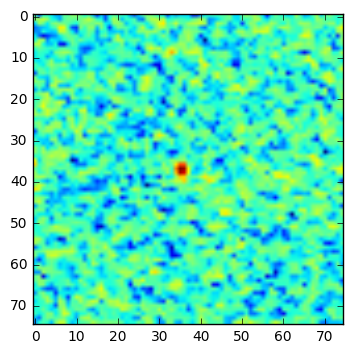

In [9]:
plt.imshow(train_samples[9][:,:,1])

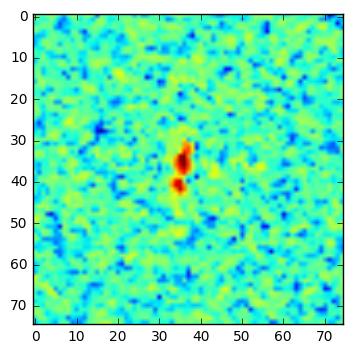

In [10]:
plt.imshow(train_samples[10][:,:,1])

In [11]:
# Split out test data
def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b)
    assert len(b) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]

train_samples, train_angles, labels = unison_shuffled_copies(train_samples, train_angles, labels)
num_train = int(len(train_samples) * 0.2)

x_train = train_samples[num_train:]
x_2_train = train_angles[num_train:]
y_train = labels[num_train:]
x_test = train_samples[:num_train]
x_2_test = train_angles[:num_train]
y_test = labels[:num_train]


# Create rotations of images
rotations = np.zeros((len(x_train), 75, 75, 2))
for index, sample in enumerate(x_train):
    rotation = rotate(sample, angle = np.random.randint(1, 10), reshape = False)
    rotations[index] = rotation
    
# Create rotations of images
rotations_2 = np.zeros((len(x_train), 75, 75, 2))
for index, sample in enumerate(x_train):
    rotation = rotate(sample, angle = np.random.randint(1, 60), reshape = False)
    rotations_2[index] = rotation
    
flips = np.zeros((len(x_train), 75, 75, 2))
for index, sample in enumerate(x_train):
    flip = np.fliplr(sample)
    flips[index] = flip
    
flipuds = np.zeros((len(x_train), 75, 75, 2))
for index, sample in enumerate(x_train):
    flipud = np.flipud(sample)
    flipuds[index] = flipud
    
flip_rots = np.zeros((len(rotations_2), 75, 75, 2))
for index, sample in enumerate(rotations_2):
    flip = np.fliplr(sample)
    flip_rots[index] = flip
    
    
x_train = np.concatenate((x_train, rotations, rotations_2, flips, flipuds), axis=0)
x_2_train = np.concatenate((x_2_train, x_2_train, x_2_train, x_2_train, x_2_train), axis=0)
y_train = np.concatenate((y_train, y_train, y_train, y_train, y_train), axis=0)


print(rotations.shape, x_train.shape)

(1284, 75, 75, 2) (6420, 75, 75, 2)


In [12]:
# Layer definitions for more complex networks

def conv_block(x, filters, size, stride=(2,2), mode='same', act=True, batchnorm=True):
    x = Conv2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization()(x) if batchnorm else x
    return Activation('relu')(x) if act else x

def res_block(ip, nf=15, downsample=False):
    shortcut = ip
    stride = (1,1)
    if downsample:
        stride = (2,2)
    x = conv_block(ip, nf, 3, stride)
    x = conv_block(x, nf, 3, (1,1), act=False)
    # Check if we need to increase dimensionality of the shortcut
    if shortcut.shape[3] != x.shape[3]:
        shortcut = conv_block(shortcut, nf, 1, stride, act=False, batchnorm=True)
    return Add()([x, shortcut])

def deconv_block(x, filters, size, stride=(2,2)):
    x = Conv2DTranspose(filters, size, size, subsample=stride, 
        border_mode='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

def up_block(x, filters, size):
    x = UpSampling2D(size=(3, 3))(x)
    x = Conv2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

class Crop(Layer):

    def __init__(self):
        super(Crop, self).__init__()


    def call(self, x):
        x[:,:75,:75,:]
        return x[:,:75,:75,:]

    def compute_output_shape(self, input_shape):
        return (None, 75, 75, 2)
    
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [13]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [60]:
# Define Generator Model
def make_generator():
    g_input = Input(shape=[100])
    H = Dense(100)(g_input)
    H = Dropout(0.2)(H)
    H = Dense(240, init='glorot_normal')(H)
    H = Reshape( [1, 1, 240] )(H)
    #for i in range(2): H = conv_block(H, 120, 3, (1,1))
    H = up_block(H, 120, 2)
    H = Dropout(0.2)(H)
    H = up_block(H, 60, 2)
    H = Dropout(0.2)(H)
    H = up_block(H, 30, 2)
    H = Dropout(0.2)(H)
    H = up_block(H, 2, 2)
    H = Dropout(0.2)(H)
    H = Conv2D(filters=15, kernel_size=3, padding='same', activation='relu')(H)
    H = Conv2D(filters=7, kernel_size=3, padding='same', activation='relu')(H)
    H = Conv2D(filters=2, kernel_size=3, padding='same', activation='tanh')(H)
    """H = deconv_block(H, 120, 3)
    H = Dropout(0.2)(H)
    H = deconv_block(H, 60, 3)
    H = deconv_block(H, 30, 3)
    H = deconv_block(H, 15, 4)
    H = deconv_block(H, 7, 8)
    H = deconv_block(H, 4, 16)
    H = deconv_block(H, 2, 32)
    H = conv_block(H, 2, 3, stride=(3,3))"""
    H = Crop()(H)
    model = Model(g_input,H)
    print (model.summary())
    return model
    

# Define Discriminative Model
# Inputs

def make_discriminator():
    band_input = Input(shape=(75, 75, 2), name='band_input')

    # CNN layers
    x = Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(band_input)
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = Dropout(0.2)(x)
    x = AveragePooling2D(pool_size=2)(x)
    cnn_out = Flatten()(x)
    x = Dense(500, activation='relu')(cnn_out)
    x = Dense(100, activation='relu')(x)
    # wasserstein customizations 
    output = Dense(1, activation=None, kernel_initializer='he_normal')(x)
    #output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[band_input], outputs=output)
    model.compile(loss=wasserstein_loss, optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9))
    print (model.summary())
    return model


generator = make_generator()
discriminator = make_discriminator()

make_trainable(discriminator, False)
# Build stacked GAN model
gan_input = Input(shape=[100])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9), loss=wasserstein_loss)
#GAN.compile(loss='binary_crossentropy', optimizer=RMSprop(clipvalue=0.01))
GAN.summary()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/kernel/__main__.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(240, kernel_initializer="glorot_normal")`
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/kernel/__main__.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(120, (2, 2), padding="same")`
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/kernel/__main__.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(60, (2, 2), padding="same")`
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/kernel/__main__.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (2, 2), padding="same")`
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/kernel/__main__.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_34 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 240)               24240     
_________________________________________________________________
reshape_7 (Reshape)          (None, 1, 1, 240)         0         
_________________________________________________________________
up_sampling2d_25 (UpSampling (None, 3, 3, 240)         0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 3, 3, 120)         115320    
__________

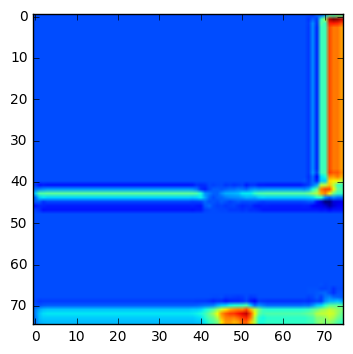

In [61]:
# Pretrain discriminator
noise_gen = np.random.uniform(-1,1,size=[200,100])
generated_images = generator.predict(noise_gen)
plt.imshow(generated_images[1][:,:,1])

In [44]:
X = np.concatenate((x_train[0:200], generated_images[0:200]))
n = X.shape[0]
y = np.zeros([n])
y[:n] = 1
y[n:] = -1


make_trainable(discriminator,True)
discriminator.fit(X,y, nb_epoch=1, batch_size=32, shuffle = True)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/kernel/__main__.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: -0.6025


In [62]:
# set up loss storage vector
losses = {"d":[], "g":[]}

def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        
        # Real image batch
        image_batch = x_train[np.random.randint(0,x_train.shape[0],size=BATCH_SIZE),:,:,:]
        
        # Generative image batch
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # Create labels for batches
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE])
        y[0:BATCH_SIZE] = 1
        y[BATCH_SIZE:] = -1
        
        
        make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
        
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE])
        y2[:] = -1
        
        make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(noise_tr, y2 )
        losses["g"].append(g_loss)

In [73]:
train_for_n(500, plt_frq=25,BATCH_SIZE=32)

100%|██████████| 500/500 [15:43<00:00,  2.22s/it]


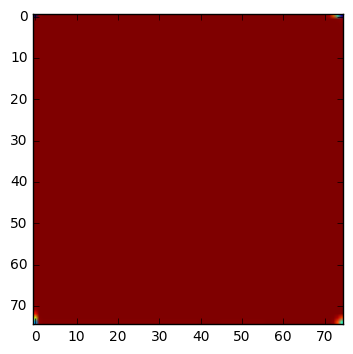

In [74]:
noise_gen = np.random.uniform(-1,1,size=[10,100])
generated_images = generator.predict(noise_gen)
plt.imshow(generated_images[9][:,:,1])

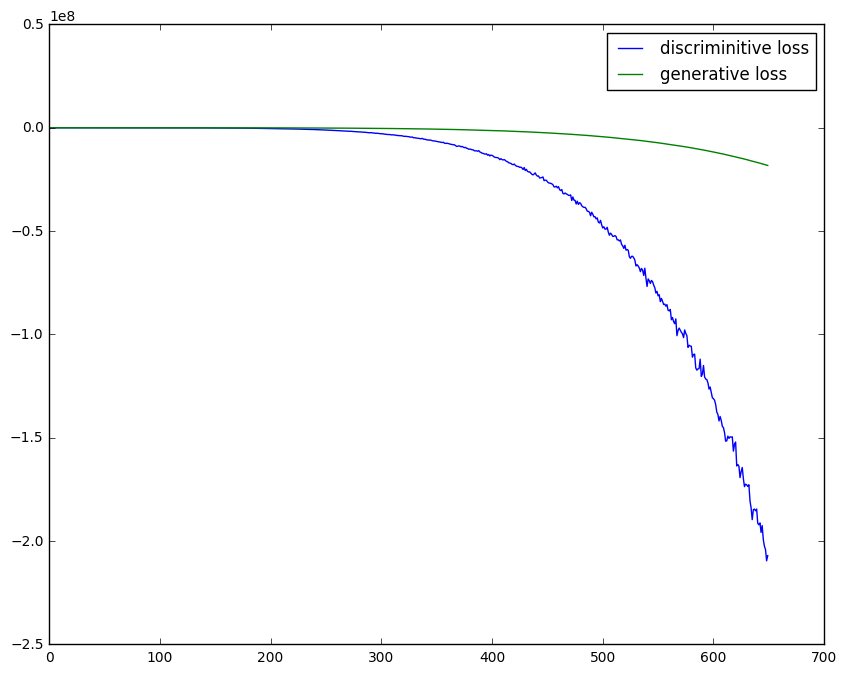

In [75]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        axes = plt.gca()
        #axes.set_ylim([0,3])
        #axes.set_xlim([0,30])
        plt.show()
plot_loss(losses)

In [72]:
losses

{'d': [-0.021345368,
  -0.13415338,
  -0.24448961,
  -0.35640761,
  -0.48882058,
  -0.68379015,
  -0.91114235,
  -1.1576726,
  -1.4808344,
  -1.9477254,
  -2.3480778,
  -2.9442244,
  -3.7096014,
  -4.3588986,
  -5.1415854,
  -6.5430584,
  -7.7699046,
  -9.4086914,
  -10.798339,
  -12.951817,
  -15.082808,
  -17.1882,
  -20.82559,
  -22.88266,
  -26.816841,
  -30.761574,
  -35.568363,
  -42.266823,
  -47.044247,
  -52.933903,
  -60.54987,
  -68.065865,
  -76.607132,
  -85.422714,
  -94.022331,
  -109.25599,
  -119.09325,
  -134.15343,
  -148.08498,
  -157.15457,
  -178.44661,
  -204.0488,
  -221.47215,
  -247.06126,
  -258.69095,
  -294.3931,
  -322.59125,
  -346.01935,
  -383.38931,
  -406.40741,
  -463.64062,
  -487.09036,
  -531.02747,
  -583.6236,
  -638.13708,
  -673.6944,
  -716.76007,
  -794.09772,
  -843.59467,
  -910.21283,
  -983.42163,
  -1128.4539,
  -1155.6163,
  -1191.0374,
  -1340.6687,
  -1395.2195,
  -1525.2572,
  -1636.1542,
  -1688.071,
  -1816.5515,
  -1965.0649,
  -

In [59]:
generated_images[1]

array([[[ 0.01078   ,  0.01233298],
        [ 0.01256632,  0.01321315],
        [ 0.01248694,  0.01333898],
        ..., 
        [ 0.01493958,  0.0160636 ],
        [ 0.01673061,  0.01726496],
        [ 0.01879106,  0.0264922 ]],

       [[ 0.01187076,  0.01200349],
        [ 0.01139425,  0.01310207],
        [ 0.01138573,  0.01331894],
        ..., 
        [ 0.01288077,  0.01510489],
        [ 0.01339602,  0.01491592],
        [ 0.02144562,  0.02414574]],

       [[ 0.0117991 ,  0.01219528],
        [ 0.011414  ,  0.01290196],
        [ 0.01143795,  0.01308177],
        ..., 
        [ 0.0164656 ,  0.01762316],
        [ 0.01658345,  0.01727544],
        [ 0.01958005,  0.02245678]],

       ..., 
       [[ 0.01912766,  0.02061377],
        [ 0.00926012,  0.01557019],
        [-0.00451343,  0.01171012],
        ..., 
        [-0.01178855,  0.11878016],
        [-0.03501932,  0.09997278],
        [-0.04519986,  0.09612982]],

       [[ 0.02343832,  0.02556424],
        [ 0.00719215,  

In [ ]:
def make_generator():
    g_input = Input(shape=[50])
    H = Dense(2*2*120, init='glorot_normal')(g_input)
    H = Reshape( [2, 2, 120] )(H)
    #for i in range(2): H = conv_block(H, 120, 3, (1,1))
    H = deconv_block(H, 60, 3)
    H = deconv_block(H, 30, 3)
    H = deconv_block(H, 15, 4)
    H = deconv_block(H, 7, 5)
    H = deconv_block(H, 4, 5)
    H = deconv_block(H, 2, 5)
    H = deconv_block(H, 2, 10)
    H = conv_block(H, 2, 3, stride=(3,3))
    H = Crop()(H)
    model = Model(g_input,H)
    print (model.summary())
    return model
    generator.compile(loss='binary_crossentropy', optimizer=RMSprop())
    generator.summary()

In [ ]:
# Resnet model

# Inputs
band_input = Input(shape=(75, 75, 2), name='band_input')
angle_input = Input(shape=(1,), name='angle_input')

x=conv_block(band_input, 15, 3, (2,2)) # Downsample by half

for i in range(2): x=res_block(x) # First resnet layer
x = Dropout(0.4)(x)
x=res_block(x, 30, downsample=True)# Downsample
for i in range(2): x=res_block(x, 30)
x = Dropout(0.4)(x)
x=res_block(x, 60, downsample=True)# Downsample
for i in range(2): x=res_block(x, 60)
x = Dropout(0.4)(x)
x=res_block(x, 120, downsample=True)# Downsample
for i in range(2): x=res_block(x, 120)
x = Dropout(0.4)(x)
x = AveragePooling2D()(x)
cnn_out = Flatten()(x)

x = concatenate([cnn_out, angle_input], name="angle_add")
x = Dropout(0.4)(x)
#x = Dropout(0.4)(cnn_out)
x = Dense(1000, activation='relu')(cnn_out)
x = Dropout(0.4)(x)
#x = concatenate([x, angle_input])
#x = Dropout(0.4)(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[band_input, angle_input], outputs=output)

model.summary()

In [ ]:
#optim = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.002)
optim = RMSprop(clipvalue=0.01) #lr=0.1

model.compile(optimizer=optim,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# train the model
checkpointer = ModelCheckpoint(filepath='nov.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10)

model.fit([x_train, x_2_train], y_train, batch_size=32, shuffle=True, validation_split=0.2, callbacks=[checkpointer, earlystop], initial_epoch=0, epochs=2000)

In [ ]:
model.load_weights('nov.weights.best.hdf5')

In [ ]:
# Less layers more aug data
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
bottleneck_model = Model(inputs=[band_input, angle_input], outputs=model.get_layer('dense_5').output)
bottleneck_samples = bottleneck_model.predict([x_train, x_2_train])

In [ ]:
bottleneck_samples.shape

In [ ]:
y_train[1].shape

In [ ]:
rfc = RandomForestClassifier()
params_rfc = {'n_estimators':[120, 300, 500, 800, 1200], 'max_depth':[5, 8, 15, 25, 30, None], 
        'min_samples_split':[2,5,10,15,100],'min_samples_leaf':[1,2,5,10],'max_features':('log2','sqrt',None)}

grid_rfc = GridSearchCV(rfc, params_rfc,n_jobs=4, scoring='roc_auc', verbose=1)
grid_rfc = grid_rfc.fit(bottleneck_samples, y_train)

In [ ]:
print(1)

In [ ]:
y_train[:].shape

In [ ]:
grid_rfc.best_score_

In [ ]:
bottleneck_test = bottleneck_model.predict([x_test, x_2_test])
x_predict = grid_rfc.predict(bottleneck_test)

In [ ]:
from sklearn.metrics import log_loss
log_loss(y_test, x_predict)

In [ ]:
y_test

In [ ]:
import torch
import torch.nn as nn
import torch.nn.parallel


class ResNet(nn.Module):
    def conv_block(self, main, name, inf, of, a, b, c, bn=True):
        """
        Arguments:
            inf: Number of input channels
            of: Number of output channels
            a: Kernel size
            b: Stride
            c: Padding
            bn: Batchnorm switch
        Returns:
            Convolutional block with batchnorm and leaky relu acitvation
        """
        main.add_module('{}-{}.{}.conv'.format(name, inf, of), nn.Conv2d(inf, of, a, b, c, bias=False))
        main.add_module('{}-{}.batchnorm'.format(name, of), nn.BatchNorm2d(of))
        main.add_module('{}-{}.relu'.format(name, of), nn.LeakyReLU(0.2, inplace=True))

    def __init__(self, isize, nc, ndf, ngpu, n_extra_layers=0):
        super(ResNet, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        main = nn.Sequential()
        # input is nc x isize x isize
        self.conv_block(main, 'initial', nc, ndf, 4, 2, 1, False)
        csize, cndf = isize / 2, ndf

        for t in range(n_extra_layers):
            self.conv_block(main, 'extra-{}'.format(t), cndf, cndf, 3, 1, 1)

        while csize > 4:
            self.conv_block(main, 'pyramid', cndf, cndf*2, 4, 2, 1)
            cndf *= 2; csize /= 2

        # state size. K x 4 x 4
        main.add_module('final.{}-1.conv'.format(cndf), nn.Conv2d(cndf, 1, 4, 1, 0, bias=False))
        self.main = main


    def forward(self, input):
        gpu_ids = None
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            gpu_ids = range(self.ngpu)
        output = nn.parallel.data_parallel(self.main, input, gpu_ids)
        output = output.mean(0)
        return output.view(1)

In [ ]:
res_net = ResNet(64,2,1,0)

In [ ]:
print(res_net)

In [ ]:
# More layers
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# More aug images
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# Resnet 13 layers
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# Resnet 13 layers
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# Predictions
prediction_array = model.predict([test_samples, test_angles])

submission = pd.DataFrame()
submission['id'] = test_id
submission['is_iceberg']=prediction_array.reshape((prediction_array.shape[0]))
submission.to_csv('sub.csv', index=False)

In [ ]:
pwd

In [ ]:
# Resnet 13 layers
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# Non Scale angle
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# Scale angle
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# large first feature map
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# with flips, less rotation
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# with rotations
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# test original model
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# Predictions
prediction_array = model.predict([test_samples, test_angles])

submission = pd.DataFrame()
submission['id'] = test_id
submission['is_iceberg']=prediction_array.reshape((prediction_array.shape[0]))
submission.to_csv('sub.csv', index=False)

In [ ]:
def sample_extractor_3channel(data_json):
    
    samples = np.zeros((len(data_json), 224, 224, 3))
    angles = np.zeros(len(data_json))

    for index, sample in enumerate(data_json):
        band_1 = np.asarray(sample['band_1']).reshape(75,75)
        band_1 = imresize(band_1, (224,224))
        band_2 = np.asarray(sample['band_2']).reshape(75,75)
        band_2 = imresize(band_2, (224,224))
        band_3 = (band_1 + band_2) / 2
        samples[index][:,:,0] = band_1
        samples[index][:,:,1] = band_2
        samples[index][:,:,2] = band_3
        inc_angle = sample['inc_angle']
        if isinstance(sample['inc_angle'], str):
            angles[index] = angle_avg
        else: 
            angles[index] = sample['inc_angle']
            
    return samples, angles
    
train_samples, train_angles = sample_extractor_3channel(train_json)
test_samples, test_angles = sample_extractor_3channel(test_json)

def mean_zero(samples, angles, band_1_avg, band_2_avg, angle_avg):
    for index, sample in enumerate(samples):
        samples[index][:,:,0] = np.subtract(sample[:,:,0], band_1_avg)
        samples[index][:,:,1] = np.subtract(sample[:,:,1], band_2_avg)
        angles[index] = np.subtract(angles[index], angle_avg)
        
    
    # Scale the samples between 0-1
    samples[:,:,:,0] = samples[:,:,:,0] + abs(np.amin(samples[:,:,:,0]))
    samples[:,:,:,1] = samples[:,:,:,1] + abs(np.amin(samples[:,:,:,1]))
    samples[:,:,:,2] = samples[:,:,:,2] + abs(np.amin(samples[:,:,:,2]))
        
    samples[:,:,:,0] = samples[:,:,:,0] / (np.amax(samples[:,:,:,0]))
    samples[:,:,:,1] = samples[:,:,:,1] / (np.amax(samples[:,:,:,1]))
    samples[:,:,:,2] = samples[:,:,:,2] / (np.amax(samples[:,:,:,2]))
    
    print(np.amax(samples[:,:,:,0]))
    print(np.amax(samples[:,:,:,1]))
    print(np.amax(samples[:,:,:,2]))
        
    print(np.amin(samples[:,:,:,0]))
    print(np.amin(samples[:,:,:,1]))
    print(np.amin(samples[:,:,:,2]))
        
    return samples, angles

train_samples, train_angles = mean_zero(train_samples, train_angles, band_1_avg, band_2_avg, angle_avg)
test_samples, test_angles = mean_zero(test_samples, test_angles, band_1_avg, band_2_avg, angle_avg)

vgg19 = Model(inputs=base_model.input, outputs=base_model.get_layer('block2_pool').output)

bottleneck_samples = vgg19.predict(train_samples)



num_train = int(len(bottleneck_samples) * 0.2)

x_train = bottleneck_samples[num_train:]
y_train = labels[num_train:]

x_test = bottleneck_samples[:num_train]
y_test = labels[:num_train]

print(bottleneck_samples.shape)

In [ ]:
model_input = Input(shape=(56, 56, 128))
#x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(model_input)
#x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=4)(model_input)
cnn_out = Flatten()(x)

x = Dropout(0.2)(cnn_out)
x = Dense(500, activation='relu')(cnn_out)
x = Dense(100, activation='relu')(x)
x = Dropout(0.2)(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=model_input, outputs=output)

model.summary()

In [ ]:
rmsprop = RMSprop(lr=1)
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# train the model
checkpointer = ModelCheckpoint(filepath='nov.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10)

model.fit(x_train, y_train, batch_size=16, validation_split=0.2, callbacks=[checkpointer, earlystop], initial_epoch=0, epochs=200)

In [ ]:
# Functional model

# Inputs
band_input = Input(shape=(75, 75, 2), name='band_input')
angle_input = Input(shape=(1,), name='angle_input')


# CNN layers
#x = Conv2D(filters=64, kernel_size=9, strides=(2, 2), padding='same', activation='relu')(band_input)# Large feature map to start
x = Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(band_input)
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = Dropout(0.2)(x)
x = AveragePooling2D(pool_size=2)(x)
cnn_out = Flatten()(x)

x = Dropout(0.2)(cnn_out)
x = Dense(500, activation='relu')(cnn_out)
x = Dense(100, activation='relu')(x)
x = Dropout(0.2)(x)
x = concatenate([x, angle_input])
x = Dropout(0.2)(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[band_input, angle_input], outputs=output)

model.summary()

In [ ]:
vgg19.summary()

In [ ]:
# Predictions
prediction_array = model.predict([test_samples, test_angles])

In [ ]:
# vgg 19 inspired
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# avg pooling
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# added deep layer
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# new functions
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# dropout 0.2
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# earlystop
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# Increase dropout to 0.4 for dense layers
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# angle last year, less deep layers
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
#moved angle one layer before the end
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
#No batch norm
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# More deep layers at end
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# Angle added after first dense layer
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# Dropout in cnn layers
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# Angle added to cnn out
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# angle as last layer
model.evaluate([x_test, x_2_test], y_test)

In [ ]:
# VGG 19 inspired

# Inputs
band_input = Input(shape=(75, 75, 2), name='band_input')
angle_input = Input(shape=(1,), name='angle_input')


# CNN layers
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(band_input)
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(band_input)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.2)(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.2)(x)

x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.2)(x)

x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.2)(x)

x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.2)(x)

cnn_out = Flatten()(x)

x = Dense(2048, activation='relu')(cnn_out)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.2)(x)
x = concatenate([x, angle_input])
x = Dropout(0.2)(x)

output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=[band_input, angle_input], outputs=output)

model.summary()

In [ ]:
# Functional model

# Inputs
band_input = Input(shape=(75, 75, 2), name='band_input')
angle_input = Input(shape=(1,), name='angle_input')


# CNN layers
x = Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(band_input)
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = Dropout(0.2)(x)
x = AveragePooling2D(pool_size=2)(x)
cnn_out = Flatten()(x)

x = Dropout(0.2)(cnn_out)
x = Dense(500, activation='relu')(cnn_out)
x = Dense(100, activation='relu')(x)
x = Dropout(0.2)(x)
x = concatenate([x, angle_input])
x = Dropout(0.2)(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[band_input, angle_input], outputs=output)

model.summary()

In [ ]:
"""
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(75, 75, 2))) 
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.summary()
"""

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
samples.shape

In [ ]:
average = 0
for index, sample in enumerate(samples):
    average = average + np.average(samples[index][0])
average

In [ ]:
# Data is not normalised
sum(train_json[0]['band_1']) / len(train_json[0]['band_1'])

In [ ]:
np.asarray()

In [ ]:
75*75

In [ ]:
array = np.asarray([1,2,3,4]).reshape(2,2)

In [ ]:
np.add(array, 5)

In [ ]:
whole_batch = int(len(train_json) / batch_size)
over_batch = int(len(train_json) % batch_size)
print("{} data points, {} batches of size {}, {} data points left over".format(len(train_json), whole_batch, batch_size, over_batch))

In [ ]:
train_json[0]['band_1']